# Лабораторная работа №1.

Работу выполнила: студентка группы 9383, Сергиенкова Анастасия. Вариант: №16.

## Задача:

1. Выполнить загрузку аудио сигнала и построить огибающую (график).
2. Фильтрация (выбрать один из 4-х основных типо фильтров). Получить фильтрованный сигнал.
3. Детектор сигнал/шум. Получчить сигнал после детектирования.
4. Эффект "Эхо". Получить сигнал после работы аудио-эффекта.
5. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Выполнение работы:

## Загрузка аудио сигнала и построение огибающей графика.

Имеется сигнал $x(i), i \in [0,N-1].$ Хотим построить огибающую $y(j), j \in [0, n-1].$ Пусть $m = [\frac{N}{n}] -$ число точек в интервале усреднения. Тогда $y(i) = \frac{1}{m}\displaystyle\sum_{k=mj}^{mj + m -1} |x(k)|$

In [1]:
import audiofile as audiofile
from scipy.io import wavfile
from scipy import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython

In [2]:
sound_rate, sound = wavfile.read('03-01-05-01-02-01-16_A16.wav')

<ipython-input-2-512a6f1562f4>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sound_rate, sound = wavfile.read('03-01-05-01-02-01-16_A16.wav')


In [3]:
n = 500
soundLenght = len(sound)
time = np.linspace(0, soundLenght, sound.shape[0])
m = int(sound.shape[0] / n)
values = np.linspace(0, soundLenght, n)
subPlot = []

for i in range(n):
    sum = 0
    for j in range(m*i, m*i+m):
        sum += np.abs(sound[j])
    subPlot.append(sum/m)

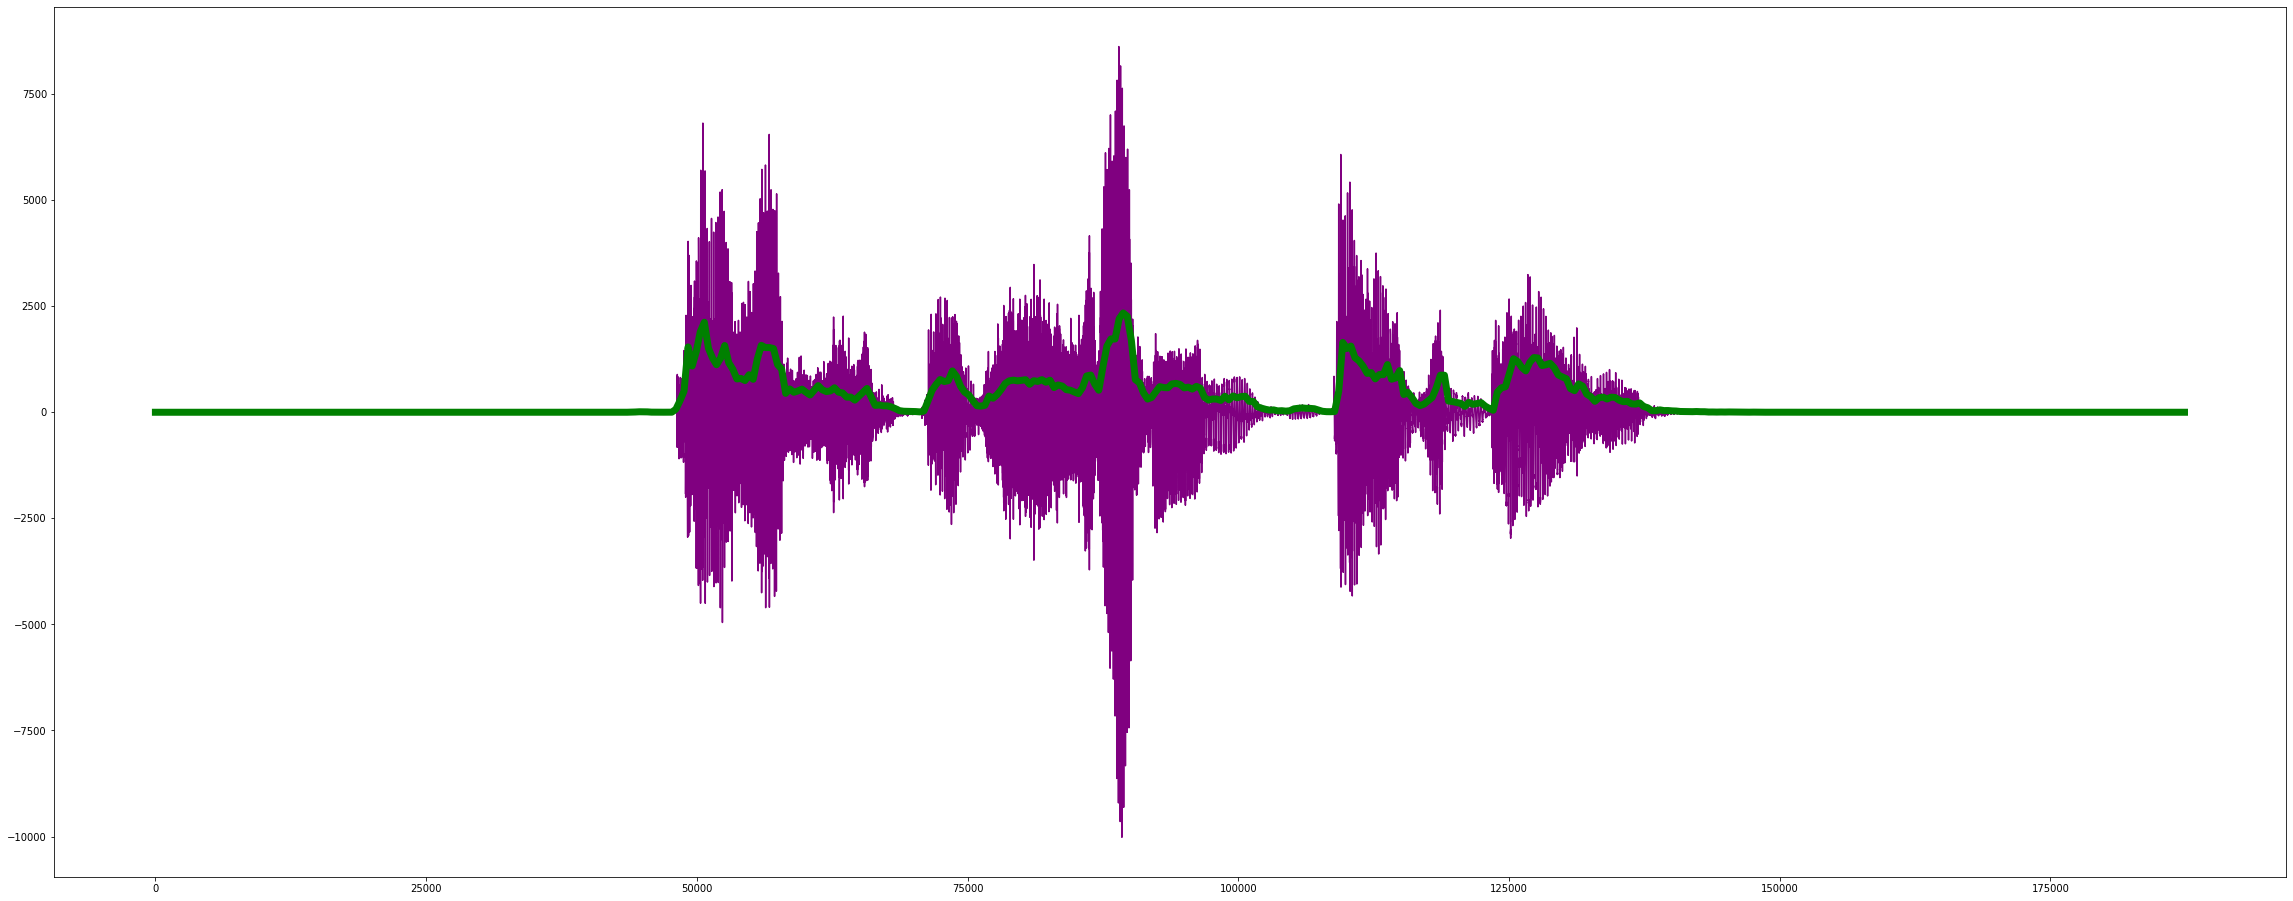

In [4]:
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(16)
plt.plot(time, sound, color="purple")
plt.plot(values, subPlot, color="green", linewidth = 7)
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.legend()
plt.show()

## Фильтрация сигнала.

Для примера возьмём фильтр нижних частот.
$F_d - $ частота дискретизации, $F_s - $ частота среза, $m - $ порядок фильтра. Требуется выслить $wn = 2\frac{F_s}{F_d}$

In [5]:
fs = 500
m = 1
wn = 2 * fs / sound_rate 
b, a = signal.butter(m, wn, "lowpass")
filtered = signal.filtfilt(b,a,sound)

wavfile.write("2.wav", sound_rate, filtered.astype(np.int16))

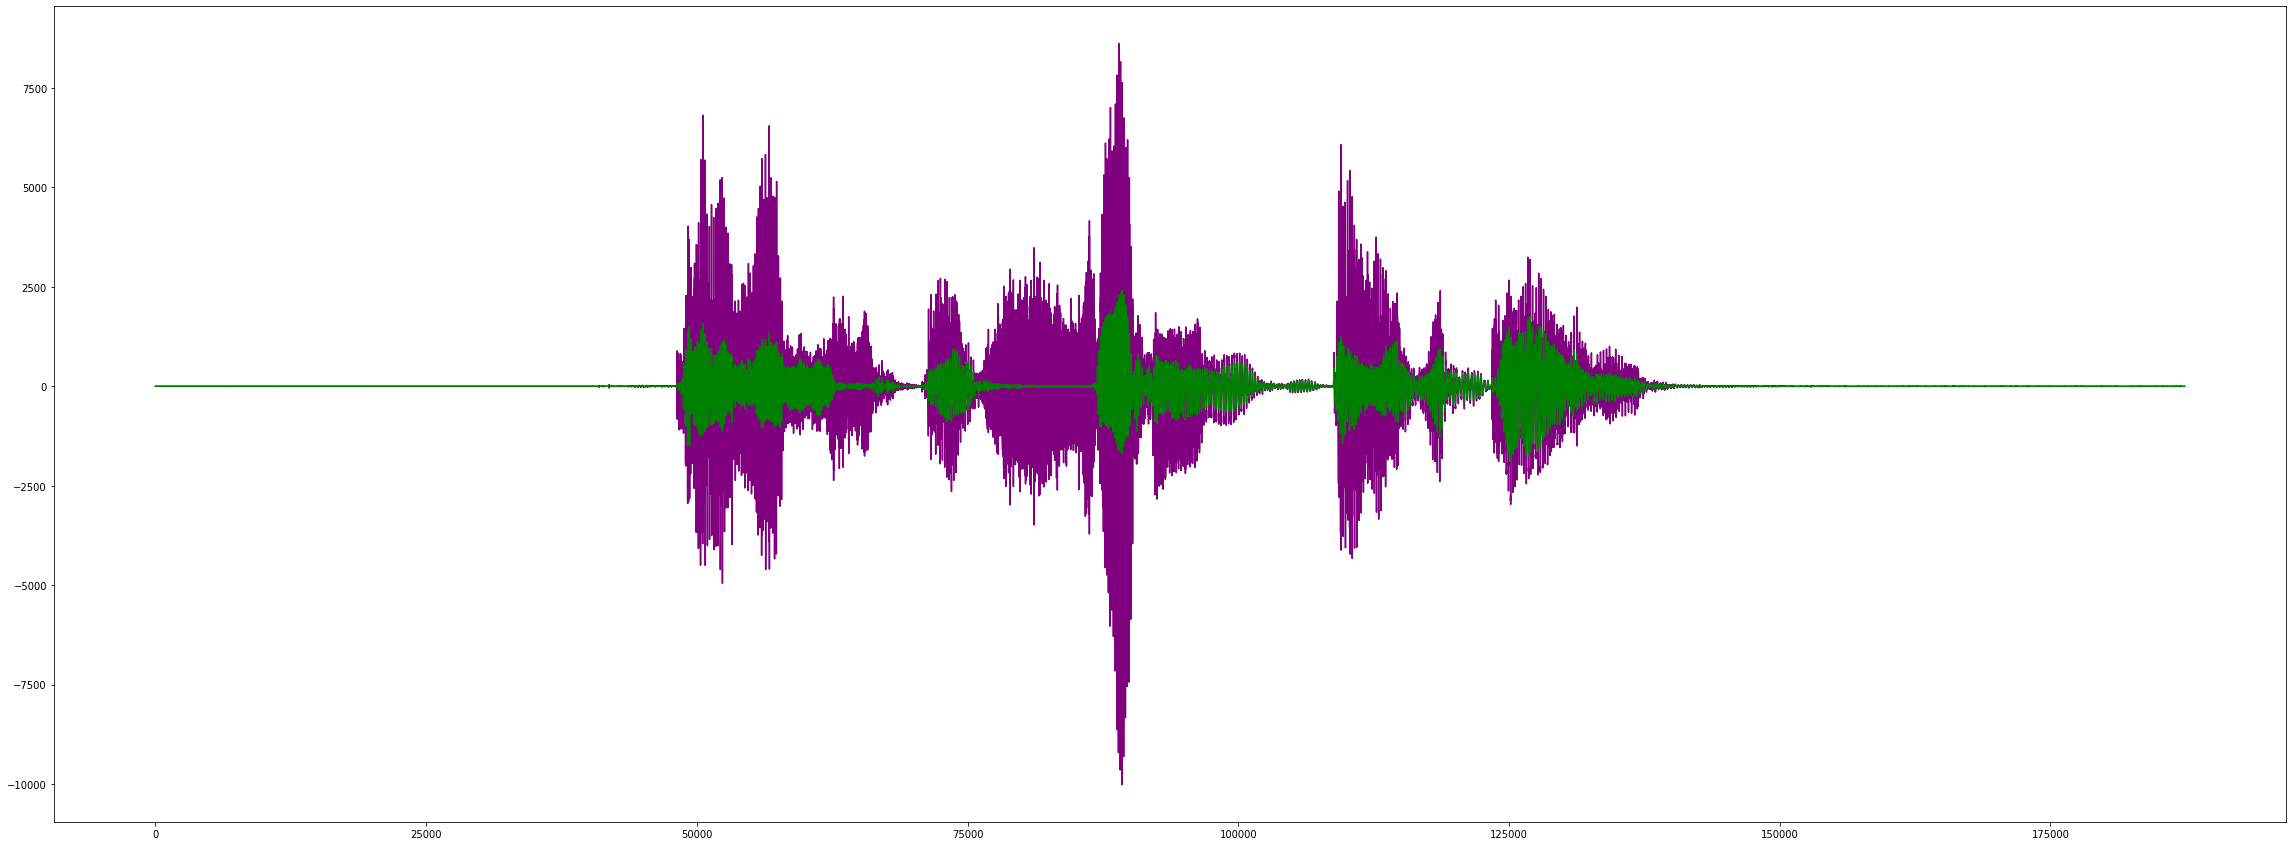

In [6]:
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(15)
plt.plot(time, sound, color="purple")
plt.plot(time, filtered, color="green")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.legend()
plt.show()


## Детектор сигнал/шум.

Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1}{N} \displaystyle\sum_{k=0}^{N-1} |x(k)| ~$.
Определяем порог детектора $- Th = \alpha \cdot mid$ , где $ 0<\alpha<1$ подбирается экспериментально. Задаём величину "провала" (в отсчётах) $k$. Обозначим $y(i)$ сигнал после детектирования $ \newline$. $ \newline$
$\bullet $ Событие "начало" сигнала. Если $x(i)$ в течении $k$ отсчётов превышает порог, $y(i) = x(i) \newline $.
$\bullet $ Событие "окончание сигнала". Если $x(i)$ в течении $k$ отсчётов меньше порога, $y(i) = 0$

In [7]:
mid = 0
alpha = 0.5

for i in range(soundLenght):
    mid += abs(sound[i])

k = 10
mid /= soundLenght
Th = alpha * mid
ok = False
counter_1 = 0
counter_0 = 0
y = np.zeros(soundLenght)

for index in range(sound.shape[0]):
    if ok:
        y[index] = sound[index]
    if abs(sound[index]) > Th:
        counter_0 += 1
        counter_1 = 0
    else:
        counter_0 = 0
        counter_1 += 1
    if counter_0 > k:
        ok = True
    else:
        ok = False
        
wavfile.write("3.wav", sound_rate, y.astype(np.int16))

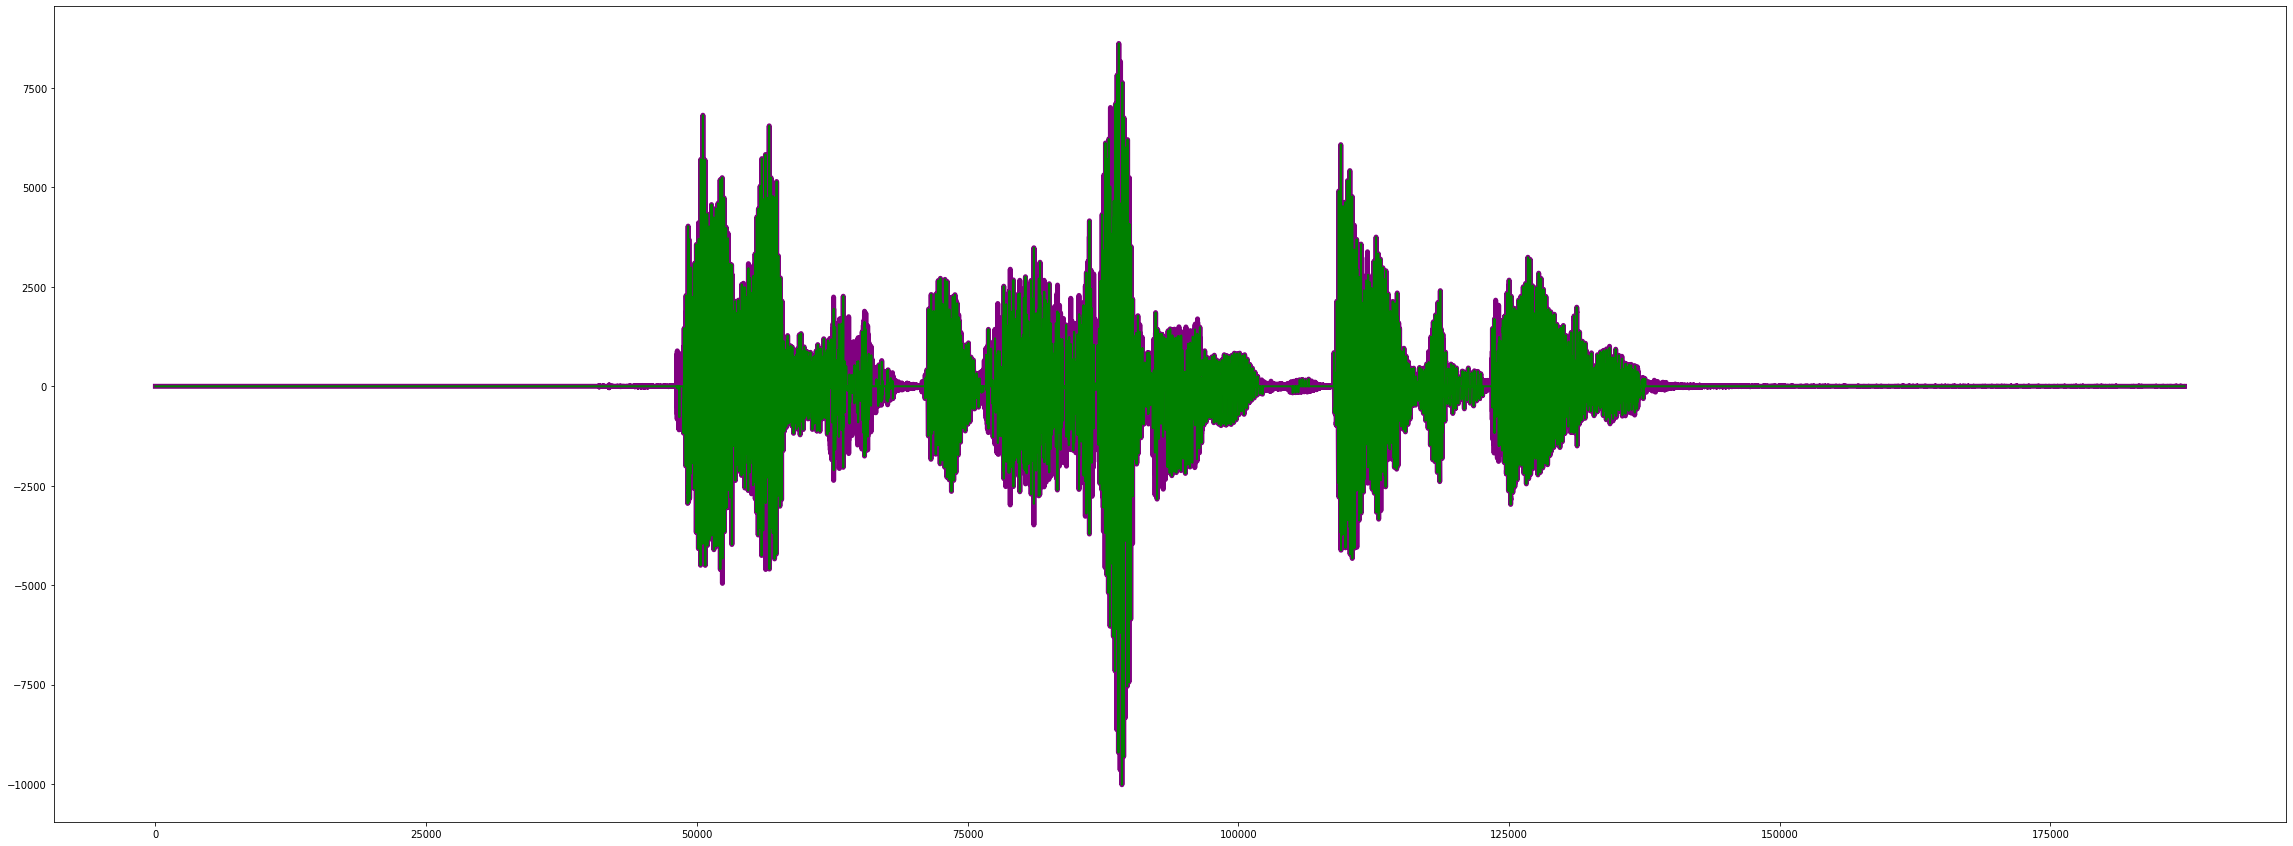

In [8]:
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(15)

plt.plot(sound, color="purple", linewidth = 5)
plt.plot(y, color="green", linewidth = 2)
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.legend()
plt.show()


## Эффект "Эхо"

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_L > 8 \newline$
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_1 > \alpha_2 > \dots > \alpha_{N_L} \newline$
Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом применимости ${\gamma}$.

Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset):
$\cdot $ Для ручного режима регулируется пользователем максимальная задержка $D1$, а велечины остальных определяются автоматически через неё: $\\D_i = D_1 \cdot 2^{\frac{1 - i}{N_L}}, i \in [2,N_L]$

$\cdot $ Для готовой конфигурации пользователь вручную задаёт последовательность: $\\ D_1 > D_2 >\dots > D_{N_L} \\ $ 

В данном примере весовые коэффициенты генерируются случайным образом, а задержки определяются по заданной максимальной задережке $D1 = 2400, {\gamma = 0.5}$

In [9]:
Di = np.zeros(8)
gamma = 0.9
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
cur = []

max = 1
Di[0] = max

In [10]:
for i in range(1, 8):
    Di[i] = max * 2**((-i)/8)
for i in range(8):
    newData = alpha[i] * sound
    cur.append(newData)

echo = np.zeros(int((np.sum(Di) + len(sound) / sound_rate + 1) * sound_rate))

for i in range(8):
    cur[i] = signal.filtfilt(b, a, cur[i])
    cur[i] = cur[i] * gamma

for i in range(8):
    if i >= 8:
        Di += Di[i-1]
    for j in range(len(cur[i])):
        echo[j + int(Di[i] * sound_rate)] += cur[i][j]
for i in range(0, len(sound)):
    echo[i] += 0.8
for i in range(0, len(sound)):
    echo[i] += sound[i]

In [11]:
wavfile.write("echo.wav", sound_rate, echo.astype(np.int16))

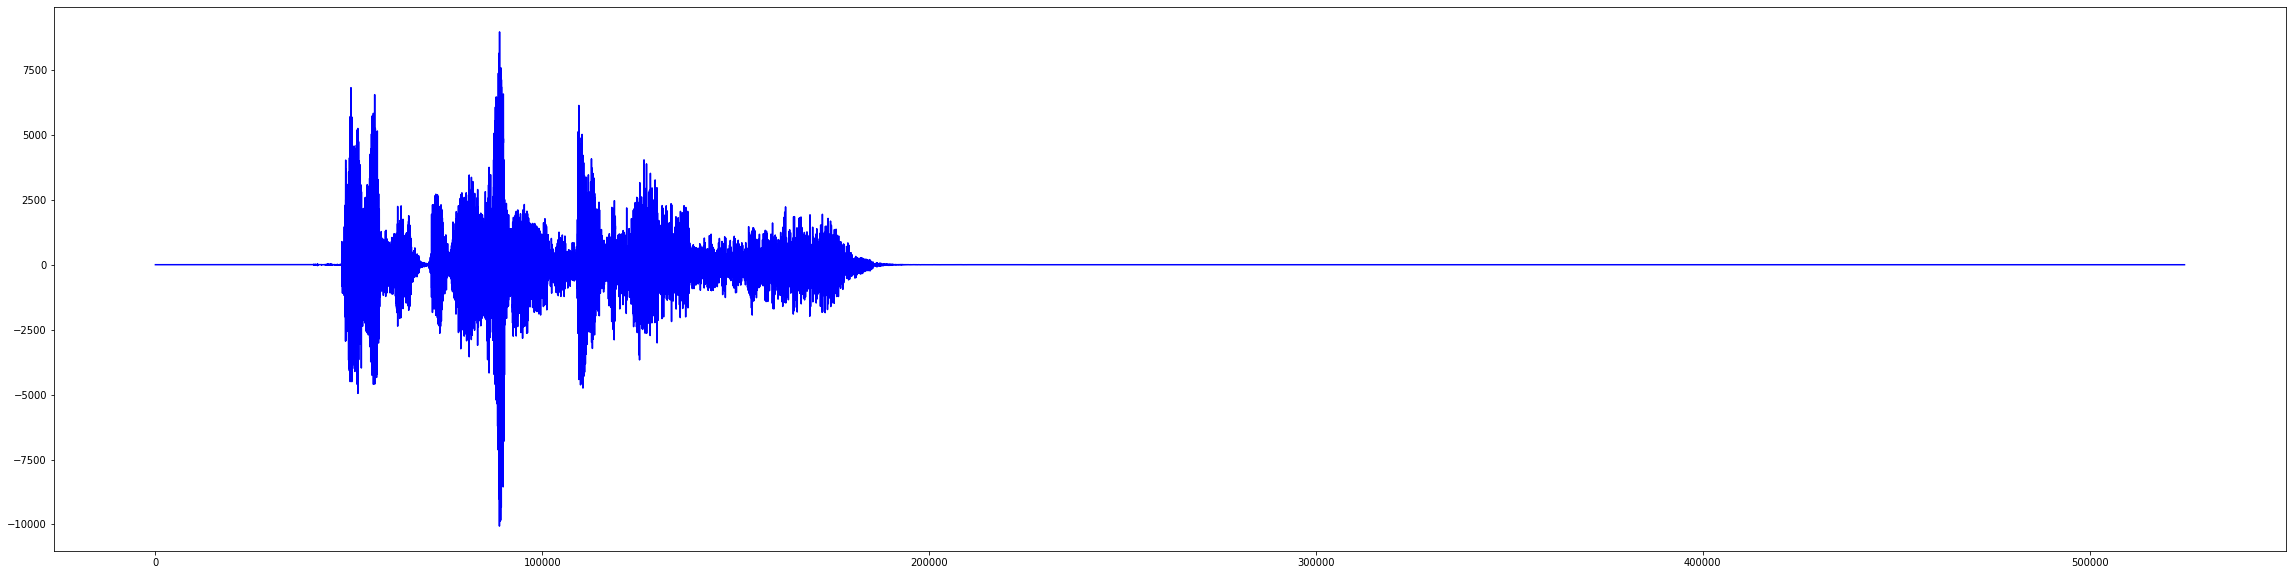

In [12]:
figure = plt.figure()
plt.plot(echo, color="blue")
figure.set_figwidth(40)
figure.set_figheight(10)
plt.show()


## Эффект "Distortion"

Обозначим входной и выходной сигналы, соотвественно как $x(i)$ и $y(i), i \in [0,N-1] \newline$
Пользователь задаёт порог $Th$ и максимальное значение сигнала $max > Th$. Тогда: $\newline$
$Y(i) =
  \begin{cases}
    x(i)       & \quad \text{if } Th \\
    max \cdot sign(x(i))  & \quad \text{if  }  |x(i)| > Th
  \end{cases}$

<ipython-input-13-7cb11554e4f3>:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


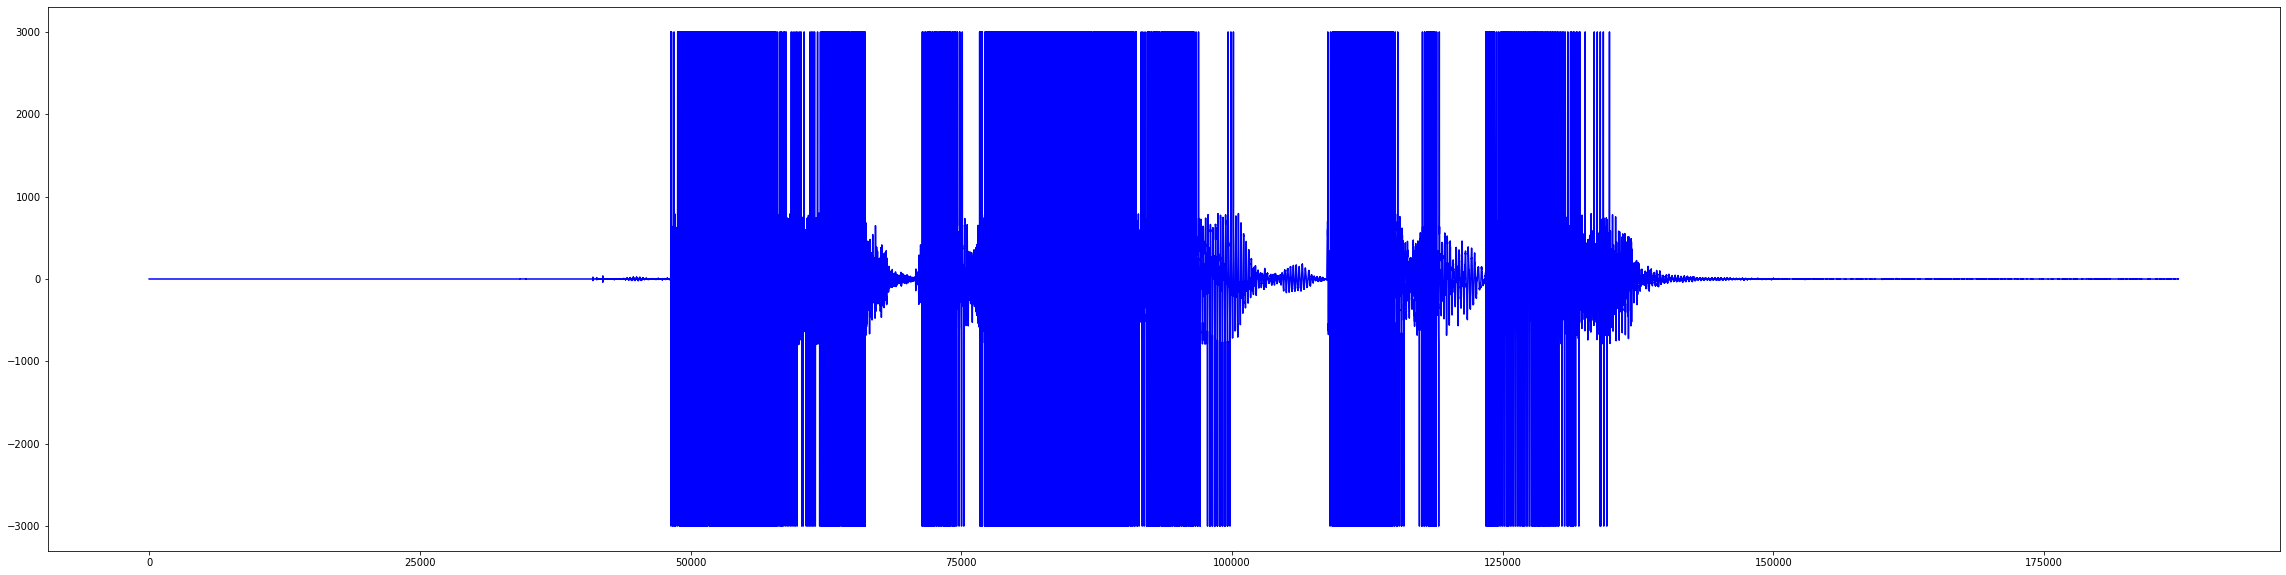

In [13]:
Th = 800
max_ = 3000
distortion_signal = []
sign = lambda x: (1, -1)[x<0]
for i in range(0,len(sound)):
    if abs(sound[i]) <= Th:
        distortion_signal.append(sound[i])
    else:
        distortion_signal.append(max_*sign(sound[i]))
figure = plt.figure()
figure.set_figwidth(40)
figure.set_figheight(10)
plt.plot(time, distortion_signal, color='blue') 
wavfile.write("4.wav",sound_rate, np.array(distortion_signal).astype(np.int16))
IPython.display.Audio(np.array(distortion_signal).astype(np.int16), rate=sound_rate)

## Вывод

В ходе выполнения лабораторной работы был получен опыт работы с цифровыми сигналами, а так же изучены возможности библиотек Python для решения задач цифровой обработки сигналов.